# installations & imports

In [ ]:
!sudo apt-get install python-numpy libicu-dev 
!pip install pyicu
!pip3 install pycld2
!pip install morfessor
#!pip install polyglot
!pip install gensim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
libicu-dev is already the newest version (60.2-3ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     |████████████████████████████████| 298 kB 35.5 MB/s 
  Created wheel for pyicu: filename=PyICU-2.7.4-cp37-cp37m-linux_x86_64.whl size=1374964 sha256=a9a5c63be51a10f9cd1fb06dc468042f527df7434e977d060d5c918cf5f80152
  Stored in directory: /root/.cache/pip/wheels/c4/3a/c8/2d2397cd8f6cd04489ecac3d1e6821bb4938d73312d69b834f
Successfully built pyicu
     |████████████████████████████████| 41.4 MB 40 kB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834284 sha256=1dc1fd65dbe7a9922ceac2e15f932e839d4da8a73aa22ecd3c54fe82714f3ecd
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614

In [ ]:

import pandas as pd
#import polyglot
#from polyglot.text import Text
import gensim 
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import random
import matplotlib.pyplot as plt
import re
import numpy as np
from gensim.matutils import unitvec


# Get data from drive
Our corpus includes the following entries:
1. article_id :  a unique id for every article in the corpus
2. newspaper code, with one of 5 newspaper codes
3. year
4. text
5. wordnumber


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_newspapers_data = pd.read_csv('drive/MyDrive/Nitzan+Sinai/MGD_LBN_MLZ_HZF_HZTfull2021-08-14.tsv', sep = '\t')

In [ ]:
all_newspapers_data.shape

(69442, 5)

In [ ]:
all_newspapers_data.head()

,article_id,newspaper-code,year,text,wordsNumber
0,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,Hebraische Ausgabe des „sraelit ווי נומע כא 2...,530.0
1,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,הנסיעה על כנפי רוח הדמיון ברום עולם כִּי אַרְא...,5669.0
2,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,ווארשויא תולדות בית בערקזא הן זאנגענבערג (הע...,3819.0
3,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,חדשות שונות (ההיזק אשר הגיע למדינת ספרד ע״י המ...,70.0
4,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,חלק בראש ולהיות ראש הועד (פרעזידענט) בהאסיפה. ...,3747.0


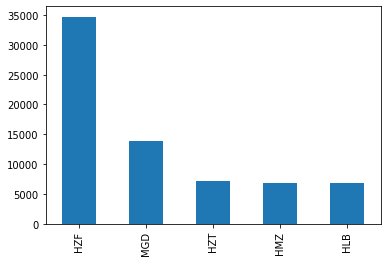

In [ ]:
# how many articles of each paper are in the corpus?
all_newspapers_data['newspaper-code'].value_counts().plot(kind='bar')

# Cleaning the data

In [ ]:
# remove nan vals
all_newspapers_data.dropna(subset = ['text'], inplace = True)

In [ ]:
# remove records with text shorter than 20 words
all_newspapers_data = all_newspapers_data[all_newspapers_data['wordsNumber'] > 20]

In [ ]:
all_newspapers_data.shape

(68968, 5)

In [ ]:
hebrew = {'א','ב','ג','ד','ה','ו','ז','ח','ט','י','כ','ל','מ','נ','ס','ע','פ','צ','ק','ר','ש','ת','ם','ף','ץ','ך','ן', ' '}
def remove_non_hebrew_chars(row):
  row['heb_text'] = row.text.replace('.', ' ')
  row['heb_text'] = row.heb_text.replace(',', ' ')
  row['heb_text'] = row.heb_text.replace('"', ' ')
  row['heb_text'] = row.heb_text.replace('-', ' ')
  row['heb_text'] = row.heb_text.replace("'", ' ')
  row['heb_text'] = ''.join(ch for ch in row.heb_text if ch in hebrew)
  return row

In [ ]:
# total number of words in the corpus
all_newspapers_data.wordsNumber.sum()

151948645.0

In [ ]:
all_newspapers_data = all_newspapers_data.apply(remove_non_hebrew_chars, axis = 1)

In [ ]:
all_newspapers_data.head()

,article_id,newspaper-code,year,text,wordsNumber,heb_text
0,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,Hebraische Ausgabe des „sraelit ווי נומע כא 2...,530.0,ווי נומע כא שנה עשירית איש יכול להשיגו...
1,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,הנסיעה על כנפי רוח הדמיון ברום עולם כִּי אַרְא...,5669.0,הנסיעה על כנפי רוח הדמיון ברום עולם כי אראה שמ...
2,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,ווארשויא תולדות בית בערקזא הן זאנגענבערג (הע...,3819.0,ווארשויא תולדות בית בערקזא הן זאנגענבערג העת...
3,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,חדשות שונות (ההיזק אשר הגיע למדינת ספרד ע״י המ...,70.0,חדשות שונות ההיזק אשר הגיע למדינת ספרד עי המרי...
4,021-HLB-1874-01-07-PG001-SINGLE-ORIGNAME_10035...,HLB,1874,חלק בראש ולהיות ראש הועד (פרעזידענט) בהאסיפה. ...,3747.0,חלק בראש ולהיות ראש הועד פרעזידענט בהאסיפה וכ...


# creating an embedding model

In [ ]:
i = 0

outp = "drive/My Drive/all_newspapers_data.txt"
output = open(outp, 'w')
space = " "

for (indx, row) in all_newspapers_data.iterrows():
  text = row.heb_text
  #article = space.join([t for t in text.split(' ')])
  output.write("{}\n".format(text))
  i += 1
  if (i % 1000 == 0):
      print("Saved " + str(i) + " articles")

output.close()

In [ ]:
def train(inp,out_model):


    model = Word2Vec(LineSentence(inp), sg = 1, # 0=CBOW , 1= SkipGram
                     size=100, window=5, min_count=2, workers=multiprocessing.cpu_count())

    model.init_sims(replace=True)

    model.save(out_model)

def getModel(model):

    model = Word2Vec.load(model)

    return model

In [ ]:
train('drive/My Drive/all_newspapers_data.txt', 'drive/My Drive/all_newspapers_data.model')

# Get similar to seed variants

In [ ]:
path = 'drive/MyDrive/Nitzan+Sinai/BHB-NLIto1920forSeed (2).tsv'
known_variants = pd.read_csv(path, encoding='utf8', sep = '\t',header=0)

In [ ]:
known_variants.head()

,attested
0,אדדעסא
1,אדיסא
2,אדיססא
3,אדעס
4,אדעסא


In [ ]:
model = getModel('drive/My Drive/all_newspapers_data.model')

In [ ]:
def findSimilarWordsFromSeed(known_variantsֹֹֹֹ):
  variants_similarity_df = pd.DataFrame(columns=['variant','variant_vector', 'similar_phrase', 'similar_phrase_vector', 'similarity','tag'])
  for variant in known_variantsֹֹֹֹ:
    if variant not in model.wv.vocab:
      print(variant)
    else:
      top_similar = model.most_similar(positive=[np.array(model[variant])], topn=20)
      for tup in top_similar:
        variants_similarity_df = variants_similarity_df.append({'variant': variant,'variant_vector':  model[variant], 'similar_phrase' : tup[0],'similar_phrase_vector':model[tup[0]], 'similarity': tup[1]}, ignore_index=True)
  return variants_similarity_df

In [ ]:
emotions = findSimilarWordsFromSeed(['תוגה', 'עצב','צער','פחד','געגוע'])
emotions.to_csv('drive/MyDrive/Nitzan+Sinai/tuga_emotions.tsv', sep = '\t')
happy_emotions = findSimilarWordsFromSeed(['שמחה', 'גיל','ששון','חדוה','חדווה','אהבה'])
happy_emotions.to_csv('drive/MyDrive/Nitzan+Sinai/happy_emotions.tsv', sep = '\t')
times = findSimilarWordsFromSeed(['אמש', 'אשתקד','מחר','שנתיים','יובל','אתמול'])
times.to_csv('drive/MyDrive/Nitzan+Sinai/times.tsv', sep = '\t')
names = findSimilarWordsFromSeed(['לינקאלן','ביסמארק','דיזראעלי','גלאדסטאן','נאפאלעאן'])
names.to_csv('drive/MyDrive/Nitzan+Sinai/names.tsv', sep = '\t')
views = findSimilarWordsFromSeed(['דעמאקראטים','ניהיליסטים','ליבעראלים','ליבעראליזמוס','מאטעריאליזמוס'])
views.to_csv('drive/MyDrive/Nitzan+Sinai/views.tsv', sep = '\t')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


געגוע
חדווה


In [ ]:
emotions.head()

,variant,variant_vector,similar_phrase,similar_phrase_vector,similarity,tag
0,תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",1.000000,NaN
1,תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",ותוגה,"[0.028818125, 0.007950918, -0.19160834, -0.033...",0.877871,NaN
2,תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",עצבת,"[0.07965497, -0.034195367, -0.069979794, -0.04...",0.849805,NaN
3,תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",עצב,"[0.041352917, -0.04432345, -0.08887646, -0.051...",0.840646,NaN
4,תוגה,"[0.07177156, -0.075532235, -0.15710847, -0.016...",ועצב,"[0.0930323, -0.128995, -0.18428303, -0.0912023...",0.822559,NaN


In [ ]:
variants_similarity_df = pd.DataFrame(columns=['variant','variant_vector', 'similar_phrase', 'similar_phrase_vector', 'similarity','tag'])
for variant in known_variants['attested']:
  variant = ''.join(ch for ch in variant if ch in hebrew)
  if variant not in model.wv.vocab:
    print(variant)
  else:
    top_similar = model.most_similar(positive=[np.array(model[variant])], topn=100)
    for tup in top_similar:
      variants_similarity_df = variants_similarity_df.append({'variant': variant,'variant_vector':  model[variant], 'similar_phrase' : tup[0],'similar_phrase_vector':model[tup[0]], 'similarity': tup[1]}, ignore_index=True)

In [ ]:
variants_similarity_df.head()

,variant,variant_vector,similar_phrase,similar_phrase_vector,similarity,tag
0,אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",1.000000,NaN
1,אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",דגיעווניק,"[-0.047209717, -0.08522165, 0.16138051, -0.096...",0.856773,NaN
2,אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",דניעוו,"[-0.062080424, 0.026962684, 0.120786585, -0.13...",0.850116,NaN
3,אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",פטרבור,"[0.004500005, 0.003853825, 0.10532285, -0.1236...",0.849917,NaN
4,אדעס,"[-0.055616375, 0.007612213, 0.11890892, -0.090...",פעטערב,"[-0.07495626, 0.0065478976, 0.102906406, -0.06...",0.846875,NaN


In [ ]:
variants_similarity_df.variant.unique()

array(['אדעס', 'אדעסא', 'אדעססא', 'אדעססע', 'אדעסע', 'אדריאנופולי',
       'אודיסא', 'אודסא', 'אודעססא', 'אוהעלי', 'אוטרעכט', 'אונגוואר',
       'אוסטראה', 'אוסטרהא', 'אוקספורד', 'אזמיר', 'אזמירנה', 'אטוואצק',
       'איגלוי', 'איזמיר', 'איטליה', 'איידטקוהנען', 'איסטאמבול',
       'אירקוטסק', 'אלגיר', 'אלטאנא', 'אלטונא', 'אלטונה', 'אלכסנדריה',
       'אלעקסאט', 'אמסטערדאם', 'אמסטרדאם', 'אמסטרדם', 'אמשטערדאם',
       'אמשטרדאם', 'אמשטרדם', 'אסטראווא', 'אפען', 'אפענבאך', 'ארגיל',
       'אתינא', 'ביינה', 'באברויסק', 'באזיליאה', 'באזעל', 'באטאשאן',
       'באטושאן', 'באלטימאר', 'באלטימארע', 'באמבערג', 'באסטאן', 'בארג',
       'בארדיטשוב', 'בבל', 'בברויסק', 'בגדאד', 'בהמבורג', 'בודאפעסט',
       'בודאפעשט', 'בוטשאטש', 'בומבאי', 'בומבי', 'בומביי', 'בוקארעסט',
       'בוקארעשט', 'בוקורעשט', 'ביאליסטאק', 'בילגוראדו', 'בילוגראדו',
       'בירות', 'במבאי', 'במבי', 'במביי', 'בסיל', 'בסיליאה', 'בענדין',
       'בענדער', 'בענדר', 'בערדיטשוב', 'בערדיטשעוו', 'בערן', 'בראדי',
       'בראילוב', 'ברדיט

In [ ]:
len(variants_similarity_df.variant.unique())

453

In [ ]:
variants_similarity_df.to_csv('drive/MyDrive/Nitzan+Sinai/top_50_similar_with_vectors.csv')

In [ ]:
variants_similarity_df = pd.read_csv('drive/MyDrive/Nitzan+Sinai/top_100_similar_with_vectors.csv')

In [ ]:
variants_similarity_df.head()

,Unnamed: 0,variant,variant_vector,similar_phrase,similar_phrase_vector,similarity,tag
0,0,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,1.000000,NaN
1,1,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,דגיעווניק,[-0.16541015 0.11892981 -0.05611533 0.103117...,0.874601,NaN
2,2,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,גאזעטטא,[-1.53306693e-01 1.80385128e-01 -2.48833988e-...,0.870141,NaN
3,3,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,ווארשאוו,[-0.13451909 0.19022076 -0.0440448 0.020023...,0.861872,NaN
4,4,אדעס,[-1.10777646e-01 1.42663047e-01 -9.60657224e-...,ווארשאווסקא,[-1.60322011e-01 1.45002767e-01 -2.88729090e-...,0.860700,NaN


# Using the model to get similar words

In [ ]:
def getModel(model):

    model = Word2Vec.load(model)

    return model

In [ ]:
model = getModel('drive/My Drive/all_newspapers_data.model')


In [ ]:
model.most_similar(positive=[np.array(model['ניהיליסטים'] ) ], topn=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ניהיליסטים', 1.0),
 ('אירלאנדים', 0.8338377475738525),
 ('ונתפשו', 0.8001390695571899),
 ('אנארכיסטים', 0.7990453839302063),
 ('סרסורי', 0.7954924702644348),
 ('סאציאליסטים', 0.7924465537071228),
 ('קומוניסטים', 0.7907980680465698),
 ('וואלאכים', 0.7880046367645264),
 ('גריכים', 0.7876204252243042),
 ('ובריטאנים', 0.7820624709129333),
 ('טענטעה', 0.7819498777389526),
 ('עלזאסים', 0.7817403078079224),
 ('מהנסיכות', 0.7797787189483643),
 ('קאמוניסטים', 0.7780557870864868),
 ('עסטעררייכים', 0.7744863033294678),
 ('סוציאליסטים', 0.7726514935493469),
 ('האנארכיסטים', 0.7718356847763062),
 ('מהשוללים', 0.7716385126113892),
 ('בהבירזא', 0.7714341282844543),
 ('נהרנו', 0.7693214416503906)]